In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from scipy.stats import pointbiserialr 
from sklearn.svm import SVC
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score,precision_score, classification_report, confusion_matrix
from imblearn.metrics import specificity_score
from matplotlib.ticker import FixedLocator
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

warnings.simplefilter(action='ignore')
# from tqdm import tqdm



Wczytanie danych

In [4]:
r_wine = pd.read_csv('data/winequality-red.csv', sep=';')
r_wine['type'] = 'red'
w_wine = pd.read_csv('data/winequality-white.csv', sep=';')
w_wine['type'] = 'white'

In [5]:
data = pd.concat([r_wine, w_wine], ignore_index=True)
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,white
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,white
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,white
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white


OPIS I WSTEPNA ANALIZA DANYCH

In [6]:
data['quality'].value_counts()

quality
6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: count, dtype: int64

Rozklad zmiennej objasnianej quality

<Axes: xlabel='quality', ylabel='count'>

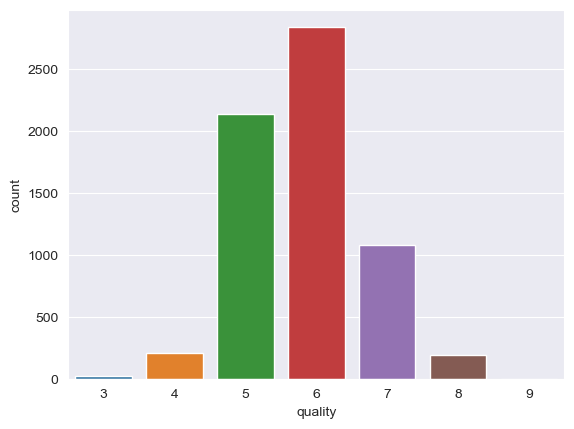

In [7]:
sns.countplot(x='quality', data=data)

Rozklad zmiennej type odpowiadajacej za kolor wina

<Axes: xlabel='type', ylabel='count'>

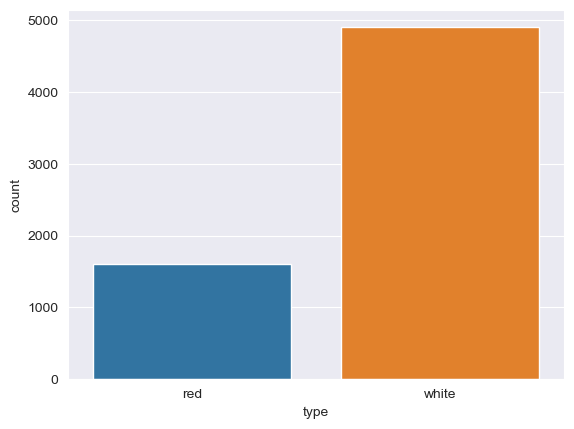

In [8]:
sns.countplot(x='type', data=data)

Typy danych w zbiorze

In [9]:
data.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
type                     object
dtype: object

Rozmiar danych

In [10]:
data.shape

(6497, 13)

Statystyki opisowe dla zmiennych liczbowych

In [11]:
data_float_column = data.select_dtypes(include=[float]).columns
data[data_float_column].describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000


PRZYGOTOWANIE DANYCH

Zamiana zmiennej quality na zmienna zero-jedynkowa quality od 3 do 6 -> 0 quality od 7 do 9 -> 1

In [12]:
data['quality'] = data['quality'].apply(lambda q: 0 if q < 7 else 1)
data['quality'].value_counts()

quality
0    5220
1    1277
Name: count, dtype: int64

Zamiana zmiennej type na zmienna zero-jedynkowa type red -> 0 type white -> 1

In [13]:
data['type'] = data['type'].apply(lambda t: 0 if t == 'red' else 1)
data['type']. value_counts()

type
1    4898
0    1599
Name: count, dtype: int64

Wartosci brakujace

In [14]:
data.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
type                    0
dtype: int64

Sprawdzenie wartosci odstajacych

In [15]:
def outliers(x, y, column, color):
    sns.boxplot(ax=axs[x][y], y=data[column], color=color)
    axs[x][y].set_title(column)
    

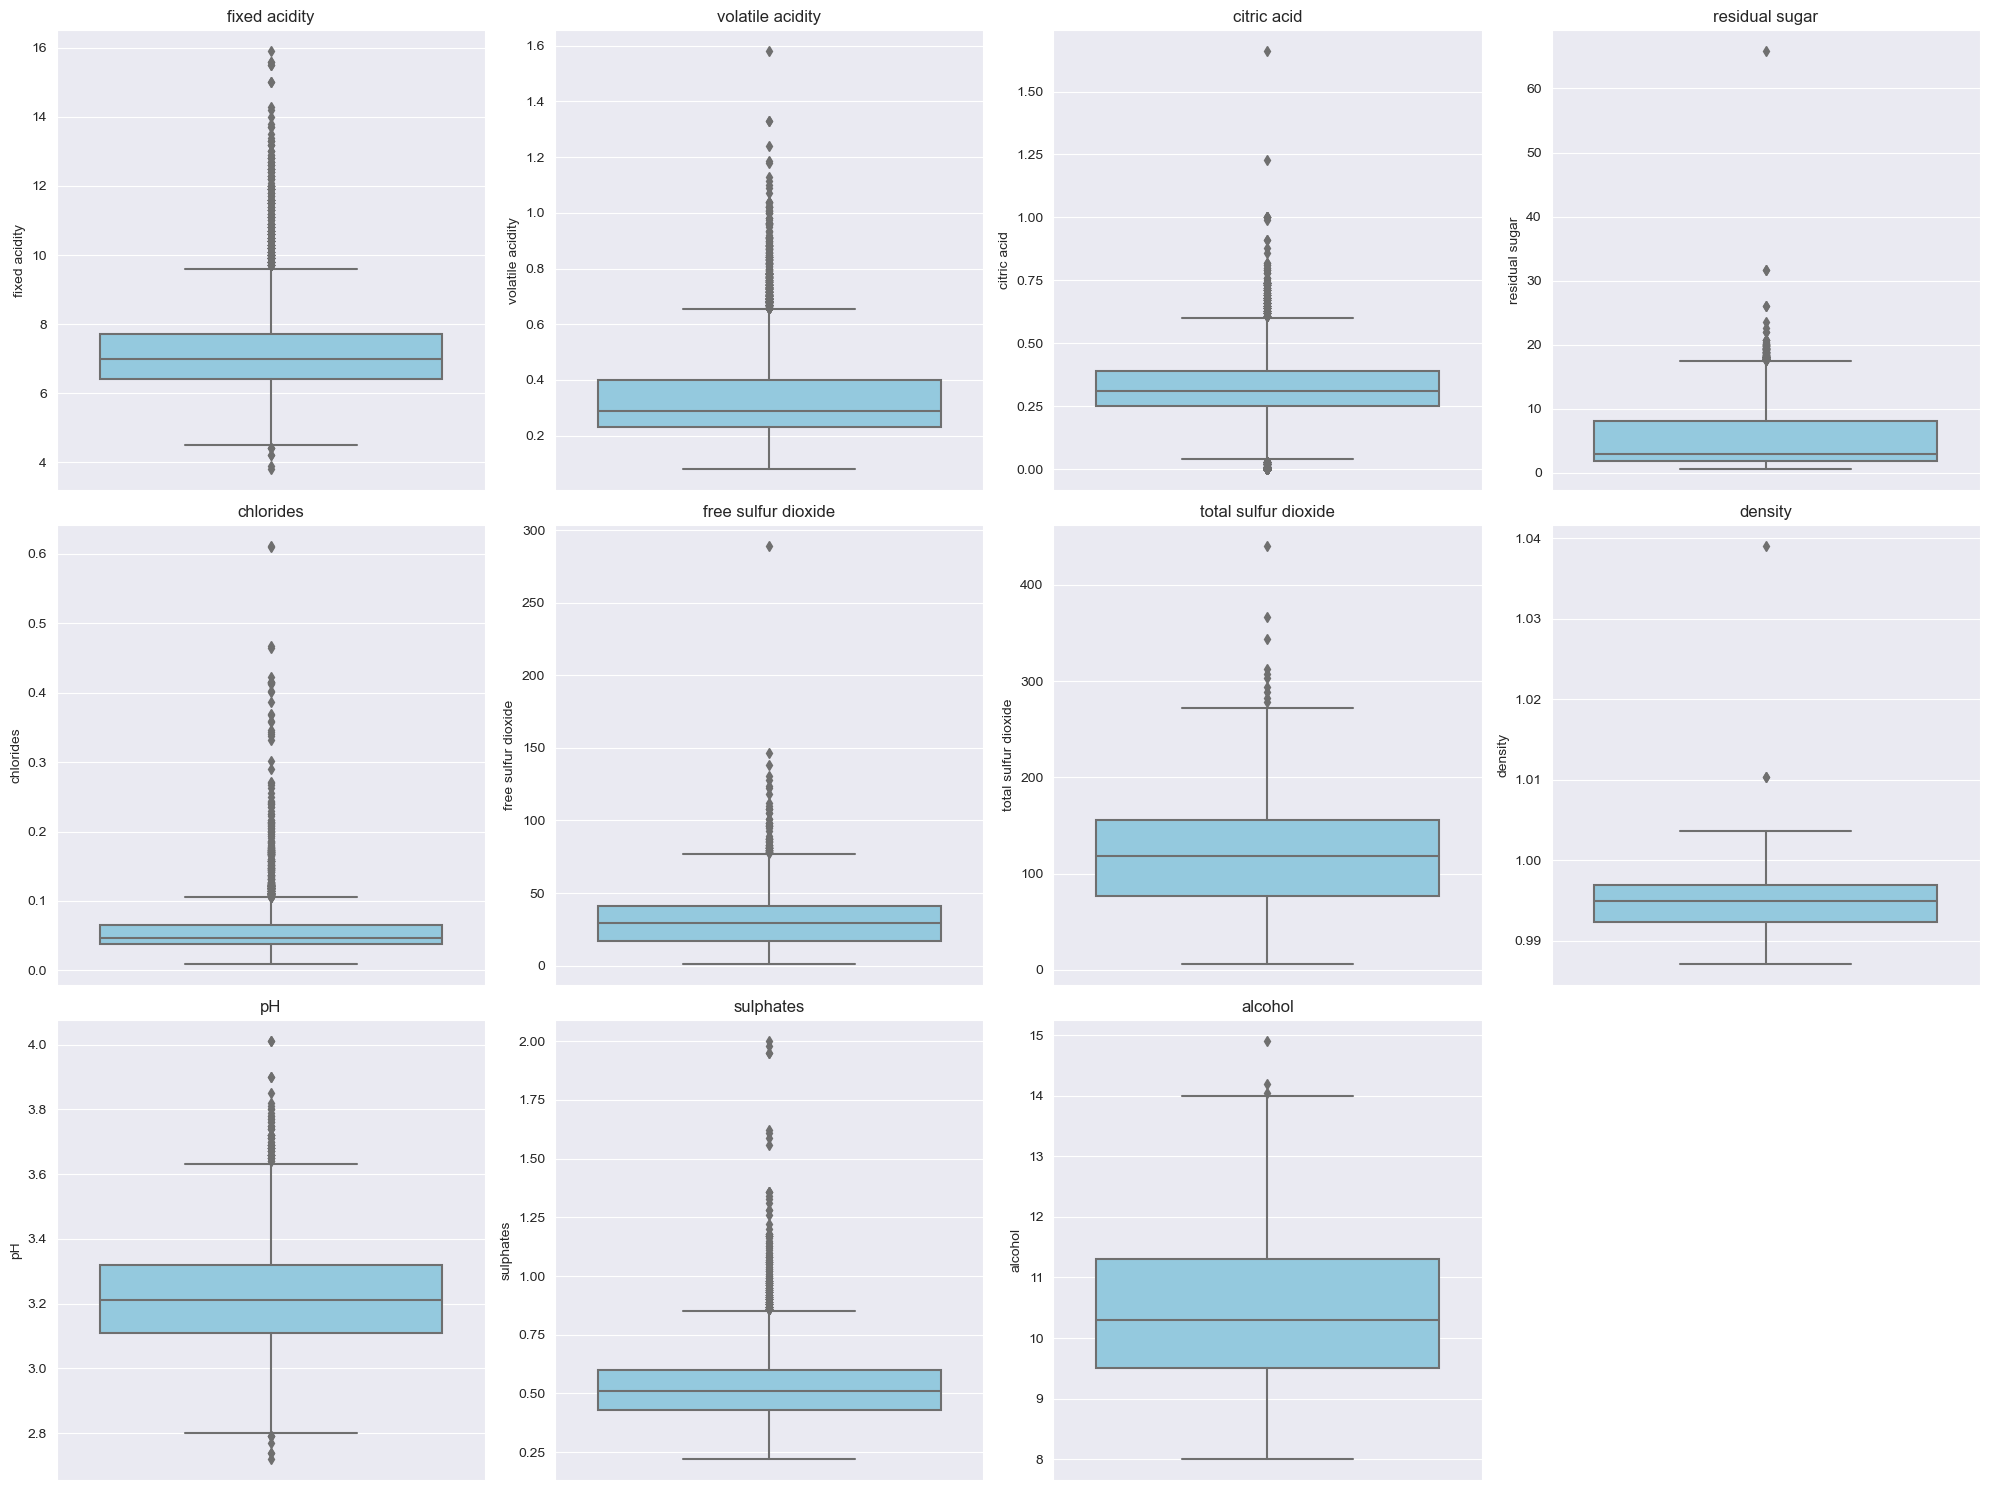

In [16]:
fig, axs = plt.subplots(ncols=4, nrows = 3, figsize=(20,15))
color = 'skyblue'
outliers(0,0, 'fixed acidity', color)
outliers(0,1, 'volatile acidity', color)
outliers(0,2, 'citric acid', color)
outliers(0,3, 'residual sugar', color)
outliers(1,0, 'chlorides', color)
outliers(1,1, 'free sulfur dioxide', color)
outliers(1,2, 'total sulfur dioxide', color)
outliers(1,3, 'density', color)
outliers(2,0, 'pH', color)
outliers(2,1, 'sulphates', color)
outliers(2,2, 'alcohol', color)
fig.delaxes(axs[2][3])
sns.set_style("darkgrid", {"grid.color": "blue", "grid.linestyle": ":"})
plt.tight_layout()
plt.show()

Analiza Wpływu Zmiennych na Zmienną Prognozowaną (Y)


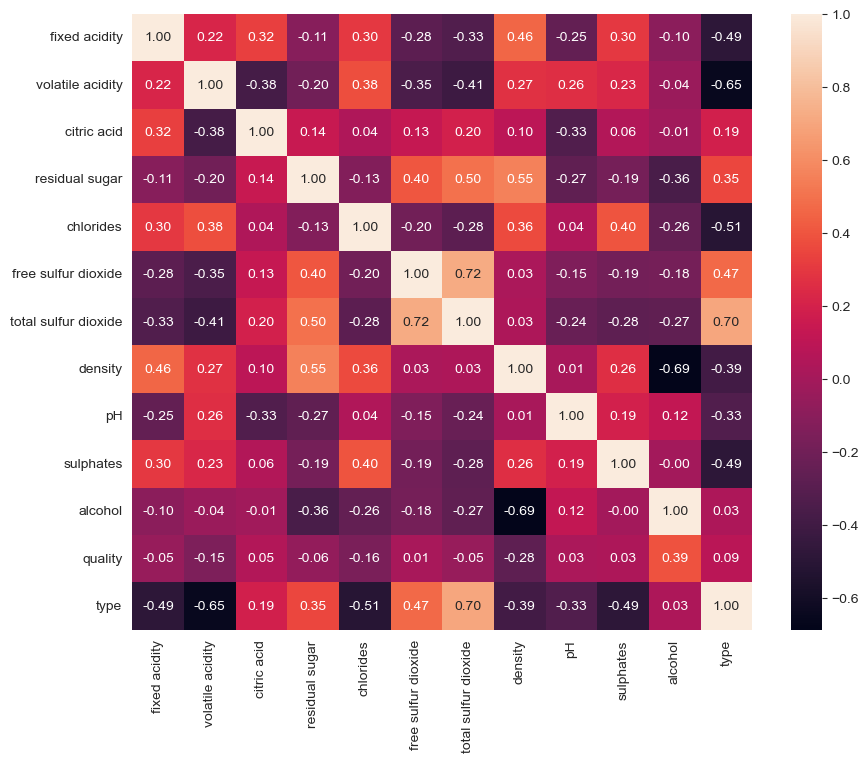

In [17]:
#heat mapa korelacji  ale nie wiem czy to dobra metoda
plt.figure(figsize=(10,8))
sns.heatmap(data.corr().drop('quality', axis=1), annot=True, fmt='.2f')
plt.show()

In [18]:
for column in data.columns.drop('quality'):
    pbc = pointbiserialr(data[column], data['quality'])
    print(f"Korelacja punktowo-biserialna między {column} a quality: {pbc.correlation:.3f}, p-wartość: {pbc.pvalue:.4f}")


Korelacja punktowo-biserialna między fixed acidity a quality: -0.049, p-wartość: 0.0001
Korelacja punktowo-biserialna między volatile acidity a quality: -0.152, p-wartość: 0.0000
Korelacja punktowo-biserialna między citric acid a quality: 0.054, p-wartość: 0.0000
Korelacja punktowo-biserialna między residual sugar a quality: -0.064, p-wartość: 0.0000
Korelacja punktowo-biserialna między chlorides a quality: -0.162, p-wartość: 0.0000
Korelacja punktowo-biserialna między free sulfur dioxide a quality: 0.015, p-wartość: 0.2340
Korelacja punktowo-biserialna między total sulfur dioxide a quality: -0.051, p-wartość: 0.0000
Korelacja punktowo-biserialna między density a quality: -0.275, p-wartość: 0.0000
Korelacja punktowo-biserialna między pH a quality: 0.028, p-wartość: 0.0233
Korelacja punktowo-biserialna między sulphates a quality: 0.034, p-wartość: 0.0062
Korelacja punktowo-biserialna między alcohol a quality: 0.390, p-wartość: 0.0000
Korelacja punktowo-biserialna między type a quality: 

PODZIAL DANYCH NA ZBIOR UCZACY I TESTOWY


In [19]:
X = data.drop('quality', axis=1)
y = data['quality']

In [20]:
#podzial na zbior testowy i treningowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
#kopia danych
X_train_svm = X_train.copy()
X_test_svm = X_test.copy()

y_train_svm = y_train.copy()
y_test_svm = y_test.copy()

Statystyki opisowe dla zbiorow

In [22]:
X_train_svm.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
count,5197.000000,5197.00000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000
mean,7.203146,0.33722,0.320275,5.471666,0.055824,30.565326,115.713392,0.994691,3.216956,0.531024,10.483601,0.757937
std,1.288267,0.16218,0.144684,4.796583,0.034830,17.439545,56.141996,0.003009,0.159628,0.148661,1.191374,0.428373
min,3.800000,0.08000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.740000,0.220000,8.000000,0.000000
25%,6.400000,0.23000,0.250000,1.800000,0.038000,17.000000,78.000000,0.992340,3.110000,0.430000,9.500000,1.000000
50%,7.000000,0.29000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994900,3.210000,0.510000,10.300000,1.000000
75%,7.700000,0.40000,0.390000,8.200000,0.064000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,1.000000
max,15.600000,1.58000,1.230000,65.800000,0.611000,146.500000,344.000000,1.038980,4.010000,2.000000,14.200000,1.000000


In [23]:
X_test_svm.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000
mean,7.263923,0.349446,0.312069,5.329577,0.056872,30.365385,115.869231,0.994720,3.224677,0.532246,10.524579,0.737692
std,1.327972,0.173832,0.147699,4.599556,0.035839,18.943749,58.037446,0.002959,0.165259,0.149438,1.197945,0.440058
min,4.400000,0.080000,0.000000,0.700000,0.016000,1.000000,8.000000,0.987580,2.720000,0.230000,8.400000,0.000000
25%,6.400000,0.230000,0.240000,1.800000,0.038000,17.000000,74.000000,0.992300,3.110000,0.430000,9.500000,0.000000
50%,7.000000,0.300000,0.300000,2.900000,0.047000,28.000000,119.000000,0.994805,3.210000,0.505000,10.400000,1.000000
75%,7.800000,0.420000,0.390000,7.800000,0.066000,41.000000,155.000000,0.996993,3.330000,0.600000,11.400000,1.000000
max,15.900000,1.240000,1.660000,26.050000,0.415000,289.000000,440.000000,1.003150,4.010000,1.950000,14.900000,1.000000


In [24]:
print(y_train_svm.value_counts())

quality
0    4172
1    1025
Name: count, dtype: int64


Balansowanie zbioru treningowego danych -  oversampling

In [25]:
smote = SMOTE(random_state=42)
X_train_svm, y_train_svm = smote.fit_resample(X_train_svm, y_train_svm)

In [26]:
print(y_train_svm.value_counts())

quality
0    4172
1    4172
Name: count, dtype: int64


Statystyki opisowe po oversamplingu

In [27]:
X_train_svm.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
count,8344.000000,8344.000000,8344.000000,8344.000000,8344.000000,8344.000000,8344.000000,8344.000000,8344.000000,8344.000000,8344.000000,8344.000000
mean,7.150328,0.318214,0.326431,5.207138,0.051384,30.829249,113.637011,0.994034,3.218915,0.534074,10.838281,0.782958
std,1.267798,0.144219,0.127815,4.510519,0.030201,16.559316,52.873044,0.003072,0.151438,0.146118,1.244519,0.412256
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.740000,0.220000,8.000000,0.000000
25%,6.400000,0.220000,0.270000,1.838436,0.035563,18.000000,84.000000,0.991480,3.120000,0.430000,9.733211,1.000000
50%,6.900000,0.280000,0.319292,3.000000,0.044000,29.373918,116.000000,0.993800,3.210702,0.510000,10.900000,1.000000
75%,7.504835,0.370000,0.387339,7.600000,0.057000,41.000000,149.000000,0.996458,3.319249,0.610000,11.838757,1.000000
max,15.600000,1.580000,1.230000,65.800000,0.611000,146.500000,344.000000,1.038980,4.010000,2.000000,14.200000,1.000000


In [28]:
X_test_svm.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000
mean,7.263923,0.349446,0.312069,5.329577,0.056872,30.365385,115.869231,0.994720,3.224677,0.532246,10.524579,0.737692
std,1.327972,0.173832,0.147699,4.599556,0.035839,18.943749,58.037446,0.002959,0.165259,0.149438,1.197945,0.440058
min,4.400000,0.080000,0.000000,0.700000,0.016000,1.000000,8.000000,0.987580,2.720000,0.230000,8.400000,0.000000
25%,6.400000,0.230000,0.240000,1.800000,0.038000,17.000000,74.000000,0.992300,3.110000,0.430000,9.500000,0.000000
50%,7.000000,0.300000,0.300000,2.900000,0.047000,28.000000,119.000000,0.994805,3.210000,0.505000,10.400000,1.000000
75%,7.800000,0.420000,0.390000,7.800000,0.066000,41.000000,155.000000,0.996993,3.330000,0.600000,11.400000,1.000000
max,15.900000,1.240000,1.660000,26.050000,0.415000,289.000000,440.000000,1.003150,4.010000,1.950000,14.900000,1.000000


Podsumowując, oversampling miał pozytywny wpływ na zdolność modeli do identyfikacji klasy mniejszościowej, co jest wskazane przez znaczący wzrost czułości. Kosztem tego było zmniejszenie specyficzności i ogólnej dokładności. To jest typowe, gdy metody balansowania klas są stosowane; modele stają się lepsze w wykrywaniu klasy mniejszościowej, ale może to również zwiększyć liczbę fałszywie pozytywnych wyników.

Decyzja, czy oversampling miał pozytywny wpływ, zależy od tego, co jest ważniejsze dla danego problemu - czy ważniejsza jest zdolność do wykrywania klasy mniejszościowej (często ważne w takich dziedzinach jak wykrywanie os

ALGORYTM SVM

Standaryzacja zmiennych

In [29]:
scaler = StandardScaler()
X_train_svm = scaler.fit_transform(X_train_svm)
X_test_svm = scaler.transform(X_test_svm)

In [30]:
def measures_score(y_true, y_pred, to_print=True, set_name='', to_return=False):
    acc = accuracy_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    spec = specificity_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    
    if to_print:
        print(f'{set_name: <5} accuracy= {round(acc, 3): <10} recall= {round(rec, 3): <12} specificity= {round(spec, 3): <15} precision= {round(prec, 3): <17}')
        
    if to_return:
        return acc, rec, spec, prec

In [31]:
# USUNAC NA KONIEC !

measures = {
    'Dokładność': [],
    'Czułość': [],
    'Specyficzność': [],
    'Precyzja': []
}

for c in range(1, 10, 1):
    model = svm.SVC(C=c)
    model.fit(X_train_svm, y_train_svm)
    y_pred_train = model.predict(X_train_svm)
    
    m = measures_score(y_train_svm, y_pred_train)
    a, r, s, p = measures_score(y_train_svm, y_pred_train, to_return=True)
    
    measures['Dokładność'].append(a)

      accuracy= 0.837      recall= 0.905        specificity= 0.769           precision= 0.797            
      accuracy= 0.837      recall= 0.905        specificity= 0.769           precision= 0.797            
      accuracy= 0.849      recall= 0.914        specificity= 0.784           precision= 0.809            
      accuracy= 0.849      recall= 0.914        specificity= 0.784           precision= 0.809            
      accuracy= 0.855      recall= 0.919        specificity= 0.791           precision= 0.814            
      accuracy= 0.855      recall= 0.919        specificity= 0.791           precision= 0.814            
      accuracy= 0.859      recall= 0.922        specificity= 0.797           precision= 0.819            
      accuracy= 0.859      recall= 0.922        specificity= 0.797           precision= 0.819            
      accuracy= 0.863      recall= 0.925        specificity= 0.802           precision= 0.824            
      accuracy= 0.863      recall= 0.925      

Algorytm SVM

In [32]:
model = svm.SVC(kernel='rbf')
model.fit(X_train_svm, y_train_svm)

y_pred_train = model.predict(X_train_svm)
measures_score(y_train_svm, y_pred_train, set_name='TRAIN')

y_pred_test = model.predict(X_test_svm)
measures_score(y_test_svm, y_pred_test, set_name='TEST')

TRAIN accuracy= 0.837      recall= 0.905        specificity= 0.769           precision= 0.797            
TEST  accuracy= 0.772      recall= 0.802        specificity= 0.765           precision= 0.451            


In [33]:
best_C = 1.0
best_kernel = 'rbf'
best_gamma = 'scale'
best_shrinking = True



In [34]:
C = np.arange(0.1, 5.1, 0.1)
kernel = ['linear', 'poly', 'rbf', 'sigmoid', 'percomputed']
gamma = np.arange(0.1, 5.1, 0.1)
shrinking = [True, False]

In [35]:
param_grid = {
    'C': C,  
    # 'gamma': [gamma, 'scale', 'auto'],
    'kernel': ['rbf']
}
# C = np.arange(0.1, 10.1, 0.1)
# decyzuje sie zmniejszyc zakres parametru C ze wzgledu na wydajnosc czasowa
# {'C': 0.1, 'kernel': 'rbf'}
# TEST  accuracy= 0.767      recall= 0.81         specificity= 0.757           precision= 0.444


In [36]:
param_grid = {
    'C': C,  
    'kernel': ['rbf'],
    'gamma': [gamma, 'scale', 'auto']
}
# Najlepsza dokładność zbalansowana: 0.8034478593000532
# {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
# TEST  accuracy= 0.758      recall= 0.806        specificity= 0.747           precision= 0.434
# 

In [37]:
param_grid = {
    'C': C,  
    'kernel': ['rbf'],
    'gamma': [gamma, 'scale', 'auto'],
    'shrinking': shrinking
}
# {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': True}
# TEST  accuracy= 0.758      recall= 0.806        specificity= 0.747           precision= 0.434

In [38]:
svc = SVC()
grid_search = GridSearchCV(svc, param_grid, cv=5,  verbose=2, n_jobs=-1)
grid_search.fit(X, y)
best_params = grid_search.best_params_
print("Najlepsze parametry:", grid_search.best_params_)
print("Najlepsza dokładność zbalansowana:", grid_search.best_score_)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Najlepsze parametry: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': True}
Najlepsza dokładność zbalansowana: 0.8034478593000532


In [39]:
best_C = best_params['C']
best_kernel = best_params['kernel']
best_gamma = best_params['gamma']
best_shrinking = best_params['shrinking']

In [41]:
model = SVC(C=best_C, kernel=best_kernel,gamma=best_gamma, shrinking=best_shrinking, random_state=42)
model.fit(X_train_svm, y_train_svm)
y_pred_test = model.predict(X_test_svm)
measures_score(y_test_svm, y_pred_test, set_name='TEST')

TEST  accuracy= 0.758      recall= 0.806        specificity= 0.747           precision= 0.434            


W kontekście wyszukiwania wyjątkowych win, gdzie być może zależy Ci na maksymalizacji czułości (recall), możesz rozważyć użycie boostingu, ponieważ często jest on w stanie lepiej wykrywać mniejszościowe klasy. 
mozna przeprowadzic drzewa decyzyjne, random forest i bosting aby zobaczyc co bedzie najlepsze.

In [ ]:
X_train_dt = X_train.copy()
X_test_dt =  X_test.copy()
y_train_dt = y_train.copy()
y_test_dt = y_test.copy()

In [ ]:
smote = SMOTE(random_state=42)
X_train_dt, y_train_dt = smote.fit_resample(X_train_dt, y_train_dt)

In [ ]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_dt, y_train_dt)
y_pred_test_dt = clf.predict(X_test_dt)
measures_score(y_test_dt, y_pred_test_dt, set_name='TEST')

In [ ]:
def subplot_measures(axs, a_x, x_values, y_test_val, y_train_val, x_label, y_label, title, display_value):
    axs[a_x].plot(x_values, y_test_val, label='testowy')
    axs[a_x].plot(x_values, y_train_val, color='r', label='treningowy')
    axs[a_x].set_title(title)
    axs[a_x].set_xlabel(x_label)
    axs[a_x].set_ylabel(y_label)
    axs[a_x].legend()   
    axs[a_x].xaxis.set_major_locator(FixedLocator(display_value))

In [ ]:
test_measures_dt = {'accuracy': [], 'recall': [], 'specificity': [], 'precision': []}
train_measures_dt = {'accuracy': [], 'recall': [], 'specificity': [], 'precision': []}
tree_depth = range(1, 20)

for depth in tree_depth:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf.fit(X_train_dt, y_train_dt)

    # Ocena na zbiorze testowym
    y_pred_test_dt = clf.predict(X_test_dt)
    measures_scores_test_dt = measures_score(y_test_dt, y_pred_test_dt, to_return=True, to_print=False)
    test_measures_dt['accuracy'].append(measures_scores_test_dt[0])
    test_measures_dt['recall'].append(measures_scores_test_dt[1])
    test_measures_dt['specificity'].append(measures_scores_test_dt[2])
    test_measures_dt['precision'].append(measures_scores_test_dt[3])

    # Ocena na zbiorze treningowym
    y_pred_train_dt = clf.predict(X_train_dt)
    measures_scores_train_dt = measures_score(y_train_dt, y_pred_train_dt, to_return=True, to_print=False)
    train_measures_dt['accuracy'].append(measures_scores_train_dt[0])
    train_measures_dt['recall'].append(measures_scores_train_dt[1])
    train_measures_dt['specificity'].append(measures_scores_train_dt[2])
    train_measures_dt['precision'].append(measures_scores_train_dt[3])

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
subplot_measures(axs, 0 , tree_depth,test_measures_dt['accuracy'], train_measures_dt['accuracy'], 'Głębokość drzewa','Dokładność', 'Dokładność',  range(1, 20, 1))
subplot_measures(axs, 1 , tree_depth,test_measures_dt['recall'], train_measures_dt['recall'], 'Głębokość drzewa','Czułość', 'Czułość',  range(1, 20, 1) )
subplot_measures(axs, 2 , tree_depth,test_measures_dt['specificity'], train_measures_dt['specificity'], 'Głębokość drzewa','Specyficzność', 'Specyficzność',  range(1, 20, 1) )
subplot_measures(axs, 3 , tree_depth,test_measures_dt['precision'], train_measures_dt['precision'], 'Głębokość drzewa','Precyzja', 'Precyzja',  range(1, 20, 1) )

Metoda Grid Search dla drzewa decyzyjnego

In [ ]:
best_criterion = 'gini'
best_max_depth = None
best_splitter = 'best'
best_min_samples_split = 2
best_min_samples_leaf = 1
best_max_features = None

In [ ]:
criterion = ['gini', 'entropy', 'log_loss']
max_depth = np.arange(0, 20, 1)
splitter = ['best', 'random']
min_samples_split = np.arange(0, 10, 1)
min_samples_leaf = np.arange(0, 10, 1)
max_features = ['auto', 'sqrt', 'log2', None]


In [ ]:
param_grid = {
    'criterion': criterion, 
    'max_depth': [max_depth, None]
}
# KOMENTARZ DO UZYSKANYCH WYNIKOW
# {'criterion': 'gini', 'max_depth': None}
# TEST  accuracy= 0.828      recall= 0.694        specificity= 0.861           precision= 0.545

In [ ]:
param_grid = {
    'criterion': criterion, 
    'max_depth': [max_depth, None],
    'splitter': splitter
    
}
# KOMENTARZ DO UZYSKANYCH WYNIKOW
# {'criterion': 'gini', 'max_depth': None, 'splitter': 'best'}
# TEST  accuracy= 0.828      recall= 0.694        specificity= 0.861           precision= 0.545

In [ ]:
param_grid = {
    'criterion': criterion, 
    'max_depth': [max_depth, None],
    'splitter': splitter,
    'min_samples_split': min_samples_split    
}
# KOMENTARZ DO UZYSKANYCH WYNIKOW
# {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 9, 'splitter': 'random'}
# TEST  accuracy= 0.816      recall= 0.706        specificity= 0.843           precision= 0.519
# czułość sie zwiekszyla a inne matryki zmniejszyly sie. Mienil sie parametr splitter na random

In [ ]:
param_grid = {
    'criterion': criterion, 
    'max_depth': [max_depth, None],
    'splitter': splitter,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}
# KOMENTARZ DO UZYSKANYCH WYNIKOW
# {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 8, 'min_samples_split': 2, 'splitter': 'random'}
# TEST  accuracy= 0.762      recall= 0.671        specificity= 0.783           precision= 0.427
# po oddaniu parametru min_samples_leaf wyniki znacznie pogorszyly sie. Branie pod uwage tego parametru nie jest pożadane. W dalszej analzie nie biore go pod uwage

In [ ]:
param_grid = {
    'criterion': criterion, 
    'max_depth': [max_depth, None],
    'splitter': splitter,
    'min_samples_split': min_samples_split,
    'max_features': max_features
}
# komentarz do uzyskanych wynikow
# {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_split': 3, 'splitter': 'best'}
# TEST  accuracy= 0.821      recall= 0.687        specificity= 0.853           precision= 0.529
# widzimy na tym etapie ze kombinacja 1/2 i 3 sa najlepsze. na tym etapie mozemy skupic sie na tamtych kombinacjach i dalej szukac lepszych parametrow 

In [ ]:
param_grid = {
    'criterion': criterion, 
    'max_depth': [max_depth, None],
    'splitter': splitter, 
    'max_features': max_features
    
}
# KOMENTARZ DO UZYSKANYCH WYNIKOW
# {'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'splitter': 'best'}
# TEST  accuracy= 0.818      recall= 0.714        specificity= 0.844           precision= 0.523
# na tym etapie zatrzymujemy sie z badaniem. Najlepsza jest 2 i 3 kombinacja param_grid
# DLA TYCH KOMBINACJI SPRAWDZMY CV = 3 I CV = 10


# cv= 3
# {'criterion': 'entropy', 'max_depth': None, 'splitter': 'best'}
# TEST  accuracy= 0.828      recall= 0.694        specificity= 0.861           precision= 0.545

# CV = 10
# {'criterion': 'gini', 'max_depth': None, 'splitter': 'random'}
# TEST  accuracy= 0.836      recall= 0.746        specificity= 0.858           precision= 0.558
# chyba najlepsze

In [ ]:
clf = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(clf, param_grid, cv=10, verbose=2, n_jobs=-1)
grid_search.fit(X, y)
best_params = grid_search.best_params_
print(f"Najlepsze parametry:", grid_search.best_params_)
print("Najlepsza dokładność zbalansowana:", grid_search.best_score_)

In [ ]:
best_criterion = best_params['criterion']
best_max_depth =  best_params['max_depth']
best_splitter = best_params['splitter']
# best_min_samples_split = best_params['min_samples_split']
# best_min_samples_leaf = best_params['min_samples_leaf']
# best_max_features = best_params['max_features']
# best_max_depth = best_params['max_depth'] 
# best_min_samples_leaf = best_params['min_samples_leaf']
# best_spliter = best_params['splitter']

In [ ]:
clf = DecisionTreeClassifier(max_depth=best_max_depth, criterion=best_criterion, splitter=best_splitter, min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf, max_features=best_max_features, random_state=42)
# clf = DecisionTreeClassifier(max_depth=best_max_depth,min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf,  criterion=best_criterion, random_state=42)

clf.fit(X_train_dt, y_train_dt)
y_pred_test_dt = clf.predict(X_test_dt)
measures_score(y_test_dt, y_pred_test_dt, set_name='TEST')

Drzewo decyzyjne wydaje sie byc słabe. Możemy spróbować przeprowadzić Boosting

Metoda Bagging

In [ ]:
bc_clf = BaggingClassifier(random_state=42, base_estimator=DecisionTreeClassifier(max_depth=None))
bc_clf.fit(X_train_dt, y_train_dt)

y_pred_test_dt = bc_clf.predict(X_test_dt)
measures_score(y_test_dt, y_pred_test_dt, set_name='TEST')

Grid Search dla metody Bagging

In [ ]:
best_n_estimators = 10 
best_max_samples = 1.0
best_max_features = 1.0
best_bootstrap = True
best_oob_score = False
best_n_jobs = None
best_base_estimator = 'deprecated'

In [ ]:
n_estimators = np.arange(1,20, 1)
max_samples = np.arange(1.0, 10.0, 1.0)
max_features = np.arange(1.0, 10.0, 1.0)
bootstrap = [True, False]
oob_score =[True, False]
n_jobs = np.arange(1, 20, 1)
base_estimator = ['deprecated', 'estimator']

In [ ]:
param_grid = {
    'n_estimators': n_estimators, 
    'max_samples': max_samples
}
#KOMENTARZ DO UZYSKANYCH WYNIKÓW 
# {'max_samples': 1.0, 'n_estimators': 18}
# TEST  accuracy= 0.874      recall= 0.75         specificity= 0.904           precision= 0.652

In [ ]:
param_grid = {
    'n_estimators': n_estimators, 
    'max_samples': max_samples,
    'max_features': max_features
}
#KOMENTARZ DO UZYSKANYCH WYNIKÓW 2
# {'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 18}
# TEST  accuracy= 0.874      recall= 0.75         specificity= 0.904           precision= 0.652

In [ ]:
param_grid = {
    'n_estimators': n_estimators, 
    'max_samples': max_samples,
    'max_features': max_features,
    'bootstrap': bootstrap
}
# KOMENTARZ DO UZYSKANYCH WYNIKÓW 2
# {'bootstrap': True, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 18}
# TEST  accuracy= 0.874      recall= 0.75         specificity= 0.904           precision= 0.652

In [ ]:
param_grid = {
    'n_estimators': n_estimators, 
    'max_samples': max_samples,
    'max_features': max_features,
    'bootstrap': bootstrap,
    'oob_score': oob_score
}
# KOMENTARZ DO UZYSKANYCH WYNIKÓW 2
# {'bootstrap': True, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 18, 'oob_score': True}
# TTEST  accuracy= 0.874      recall= 0.75         specificity= 0.904           precision= 0.652

In [ ]:
param_grid = {
    'n_estimators': n_estimators, 
    'max_samples': max_samples,
    'max_features': max_features,
    'bootstrap': bootstrap,
    'oob_score': oob_score,
    'n_jobs': [n_jobs, best_n_jobs]
    
}
# KOMENTARZ DO UZYSKANYCH WYNIKÓW 2
# {'bootstrap': True, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 18, 'n_jobs': None, 'oob_score': True}
# TEST  accuracy= 0.874      recall= 0.75         specificity= 0.904           precision= 0.652

In [ ]:
param_grid = {
    'n_estimators': n_estimators, 
    'max_samples': max_samples,
    'max_features': max_features,
    'bootstrap': bootstrap,
    'oob_score': oob_score,
    'n_jobs': [n_jobs, best_n_jobs], 
    'base_estimator': base_estimator
}
# KOMENTARZ DO UZYSKANYCH WYNIKOW 2
#   {'base_estimator': 'deprecated', 'bootstrap': True, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 18, 'n_jobs': None, 'oob_score': True}
# TEST  accuracy= 0.874      recall= 0.75         specificity= 0.904           precision= 0.652

In [ ]:
# wyniki nie poprawily sie po wprowadzeniu roznych wartosci parametrów. Przystepujemy do zmiany parametru cv i param_grid  ostatnio przetestowanego

In [ ]:
bc_clf = BaggingClassifier(random_state=42)
grid_search = GridSearchCV(bc_clf, param_grid, cv=10, verbose=2, n_jobs=-1)
grid_search.fit(X, y)
best_params = grid_search.best_params_
print(f"Najlepsze parametry:", grid_search.best_params_)
print("Najlepsza dokładność zbalansowana:", grid_search.best_score_)


In [ ]:
best_n_estimators = best_params['n_estimators']
best_max_samples = best_params['max_samples']
best_max_features = best_params['max_features']
best_bootstrap  = best_params['bootstrap']
best_oob_score = best_params['oob_score']
best_n_jobs = best_params['n_jobs']
best_base_estimator = best_params['base_estimator']

In [ ]:
bc_clf = BaggingClassifier(n_estimators=best_n_estimators,max_samples=best_max_samples, max_features=best_max_features,bootstrap=best_bootstrap ,oob_score=best_oob_score ,n_jobs=best_n_jobs,base_estimator=best_base_estimator,  random_state=42)

bc_clf.fit(X_train_dt, y_train_dt)
y_pred_test_dt = bc_clf.predict(X_test_dt)
measures_score(y_test_dt, y_pred_test_dt, set_name="TEST")

In [ ]:
# ZMIANY PARAMETRÓW NIE PRZYNIOSLY KORZYSCI DLATEGO PRZYSTEPUJEMY DO BADANIA WPLYWU WARTOSCI PARAMETRU CV W METODZIE GRID SEARCH
# POPZEDNIE BADANIA WYKONYWANE BYŁY NA CV=5
# DLA CV = 2 I OSTTANIE KOMBINACJI PARAMETRÓW
# TEST  accuracy= 0.874      recall= 0.75         specificity= 0.904           precision= 0.652   -  BEZ POPRAWY
# DLA CV = 10
# TEST  accuracy= 0.874      recall= 0.75         specificity= 0.904           precision= 0.652   -  BEZ POPRAWY

# NAJLEPSZE MOŻLIWE WARTOSCI PARAMETRÓW ZOSTALY ZNALEZIONE
# MOZNA ZDECYDOWAC SIE USUNAC PARAMETRY KTORA ZA KAZDYM BADANYM RAZEM PRZYJELY WARTOSCI DEFAULT

